# Music structure boundary estimation from low-rank Laplacian approximations
##### Music Information Retrieval, Final Project, Christos Plachouras

Notebook to compute graph Laplacian for all audio in SALAMI 2.0, train a CNN from it to produce boundary predictions, and evaluate them.

### Imports

In [241]:
import pathlib  # for finding files in directories
import sys  # for showing file loading progress bar
import librosa  # for audio processing
import librosa.display  # for plotting
import numpy as np  # for matrix and signal processing
import scipy  # for matrix processing
import cv2  # for image scaling
from numba import jit  # for speeding up repetitive processes
from scipy.spatial.distance import pdist, squareform # for eigenvector set distances
import matplotlib.pyplot as plt

### Graph Laplacian and approximations

We first construct the graph Laplacian. This is done from two features. We first construct a weighted affinity graph from the Constant-Q Transform, and do some filtering to enhance the diagonals, encoding repetition patterns. Although the original method operates with feature beat-synchronization, we will skip this to keep reference to user structure boundary annotations without depending on the accuracy of the beat tracking. We'll alleviate this to some extend using further filter and diagonal enhancement. We then compute a sequence matrix from the MFCCs, to enconde local consistency. We downsample both matrices to have 2 frames per second (to accomodate the standard +-0.5second estimation tolerance), and compute the weighted combination of the two. From that, we compute the graph Laplacian, and using the distance of sets of the first eigenvectors of it, we construct low-rank approximations.

In [93]:
"""
Segmentation code derivative of:
     https://github.com/bmcfee/lsd_viz (MIT license)
with subsequent modifications from:
    https://github.com/chrispla/hierarchical_structure (MIT license)
and further modifications in this notebook.
"""

@jit(forceobj=True)
def compute_laplacian(path, bins_per_octave, n_octaves, hop_length, downsampling):
    """Compute the Laplacian matrix from an audio file using
    its Constant-Q Transform.

    Args:
        path: filepath (str)
        bins_per_octave: number of bins per octave for CQT calculation
        n_octaves: number of octaves for CQT calculation

    Returns:
        L: Normalized graph Laplacian matrix (np.array)
        
    """

    # load audio
    y, sr = librosa.load(path, sr=16000, mono=True)

    # Compute Constant-Q Transform in dB
    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y,
                                                   sr=sr,
                                                   bins_per_octave=bins_per_octave,
                                                   n_bins=n_octaves * bins_per_octave,
                                                   hop_length=hop_length)),
                                                   ref=np.max)

    # we won't beat-synchronize, to keep reference to user annoations without
    # depending on accuracy of beat tracking. We'll instead downsample the hopped
    # CQT and MFCCs by a factor of 15,625, to comform with the standard +-0.5
    # second tolerance for estimation
    Cdim = cv2.resize(C, (int(np.floor(C.shape[1]/downsampling)), C.shape[0]))

    # stack 4 consecutive frames
    Cstack = librosa.feature.stack_memory(Cdim, n_steps=4)

    # compute weighted recurrence matrix
    R = librosa.segment.recurrence_matrix(Cstack, width=3, mode='affinity', sym=True)

    # enhance diagonals with a median filter
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    Rf = librosa.segment.path_enhance(Rf, 15)

    # compute MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length)
    Mdim = cv2.resize(mfcc, (int(np.floor(mfcc.shape[1]/downsampling)), mfcc.shape[0]))

    # build the MFCC sequence matrix
    path_distance = np.sum(np.diff(Mdim, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

    # get the balanced combination of the MFCC sequence matric and the CQT
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)
    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
    A = mu * Rf + (1 - mu) * R_path

    # compute the normalized Laplacian
    L = scipy.sparse.csgraph.laplacian(A, normed=True)

    return L

@jit(forceobj=True)
def decompose_laplacian(L, k1, k2):
    """Decompose Laplacian and make sets of its first integer k (k1 or k2) eigenvectors.
    For each set, compute its Euclidean self distance over time.

    Args:
        L: Laplacian matrix (np.array)
        k1: first-eigenvectors number for first set (int)
        k2: first-eigenvectors number for secomd set (int)

    Returns:
        distances: self distance matrix of each set of first eigenvectors (np.array, shape=(kmax-kmin, 512, 512))
    """

    # eigendecomposition
    evals, evecs = scipy.linalg.eigh(L)

    # eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))

    # normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5

    # initialize set
    distances = []

    for k in [k1, k2]:
        # create set using first k normalized eigenvectors
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]

        # get eigenvector set distances
        distance = squareform(pdist(Xs, metric='euclidean'))
        distances.append(distance)

    return np.asarray(distances)

@jit(forceobj=True)
def get_representations(path):
    """Simple end-to-end call for getting the three representations
    
    Args:
        path: audio path (str)
        k1: first-eigenvectors number for first set (int)
        k2: first-eigenvectors number for secomd set (int)
    
    Returns:
        tuple:
            Laplacian: Normalized graph Laplacian matrix (np.array)
            approximation k1: self-distance matrix for k1 set (np.array)
            approximation k2: self-distance matrix for k2 set (np.array)
    """
    L = compute_laplacian(path=path, 
                          bins_per_octave=12*3, 
                          n_octaves=7,
                          hop_length=512, 
                          downsampling=15.625)

    d = decompose_laplacian(L=L, k1=4, k2=9)

    return (L, d[0], d[1])



### Checkerboard kernel

We will slide a checkerboard kernel across the Laplacians and their approximations to measure novelty across time. We will use a smoothened kernel with a radially symmetric gaussian function to avoid big spikes over sharp edge artifacts.

In [204]:
"""
Checkerboard kernel and novelty function code with minor modifications from:
    FMP Notebooks, C4/C4S4_NoveltySegmentation.ipynb
    which is an implementation of:
        Jonathan Foote: Automatic audio segmentation using a measure of audio 
        novelty. Proceedings of the IEEE International Conference on Multimedia 
        and Expo (ICME), New York, NY, USA, 2000, pp. 452–455.
"""

@jit(nopython=True)
def compute_kernel_checkerboard_gaussian(l=20, var=1, normalize=True):
    """Compute Guassian-like checkerboard kernel.

    Args:
        l: Parameter specifying the kernel size M=2*l+1 (int)
        var: Variance parameter determing the tapering (epsilon) (float)
        normalize: Normalize kernel (bool)

    Returns:
        kernel: Kernel matrix of size M x M (np.ndarray)
    """

    taper = np.sqrt(1/2) / (l * var)
    axis = np.arange(-l, l+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

# @jit(nopython=True)
def compute_novelty(S, l=20, var=0.5, exclude=True):
    """Compute novelty function from SSM.

    Args:
        S: SSM (np.ndarray)
        l: Parameter specifying the kernel size M=2*l+1  (int)
        var: Variance parameter determing the tapering (epsilon) (float)
        exclude: Sets the first l and last l values of novelty function to zero (bool)

    Returns:
        nov (np.ndarray): Novelty function
    """

    kernel = compute_kernel_checkerboard_gaussian(l=l, var=var)
    N = S.shape[0]
    M = 2*l + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, l, mode='constant')

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([l, N])
        left = np.max([0, N-l])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov


### Experiment

Before computing estimating the boundaries for all songs in the dataset and evaluating the performnce, let's see how the methods proposed work on the first song in the dataset.

In [249]:
# change to whatever audio you want to try here
audio_path = "../salami-audio/2/audio_mp3-to.wav"

# store all variables and features in this experiment in a dictionary for easier retrieval
# c1: Laplacian, c2: approximation 1, c3: approximation 2
exp = {'c1': {}, 'c2': {}, 'c3': {}}

# get representations and compute novelty
exp['c1']['rep'], exp['c2']['rep'], exp['c3']['rep'] = get_representations(audio_path)
for case in ['c1', 'c2', 'c3']:
    exp[case]['nov'] = np.abs(compute_novelty(exp[case]['rep'], l=20))

# we want to define a threshold value for choosing novelty peaks to consider as boundaries
# for this experiment, let's define it as 70% of the difference between the global maximum
# and the non-zero global minimum of novelties.
ptp = 0.7  

for case in ['c1', 'c2', 'c3']:

    gmax = np.amax(exp[case]['nov'])
    gmin = np.amin(exp[case]['nov'][np.nonzero(exp[case]['nov'])])

    pt = gmin + (ptp * abs(gmax - gmin))
    exp[case]['pt'] = pt
    exp[case]['peaks'] = scipy.signal.find_peaks(exp[case]['nov'], height=pt)

Let's plot the boundary estimation.

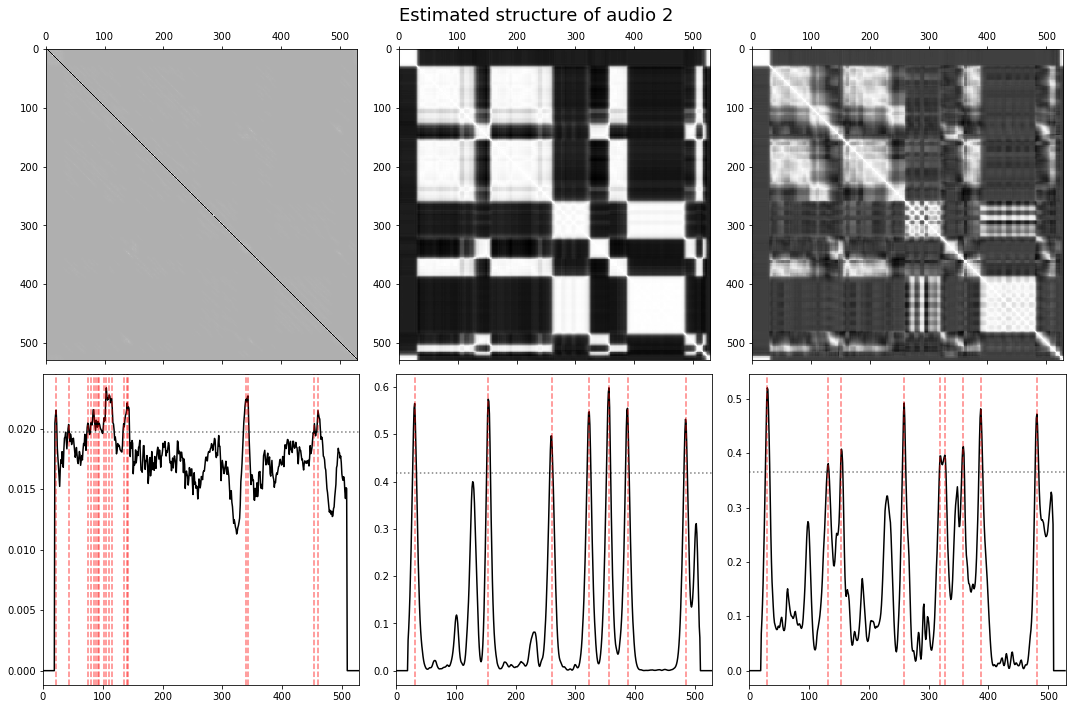

In [250]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, case in enumerate(['c1', 'c2', 'c3']):

    ax[0, i].matshow(exp[case]['rep'], cmap='Greys')
    ax[1, i].plot(exp[case]['nov'], color='black')
    ax[1, i].set_xlim(0, exp[case]['nov'].shape[0])
    ax[1, i].axhline(exp[case]['pt'], color='black', ls=':', alpha=0.5)
    for peak in exp[case]["peaks"][0]:
        ax[1, i].axvline(peak, color='r', ls='--', alpha=0.5)

fig.suptitle("Estimated structure of " + "audio 2", fontsize=18) 
plt.tight_layout()
plt.show()

We observe that the original graph Laplacian has "too many details", as it's the granular representation of repetition links. Let's make an exception and define a "radius" around which a local maximum can exist without other local maximums, with the smaller ones discarded.

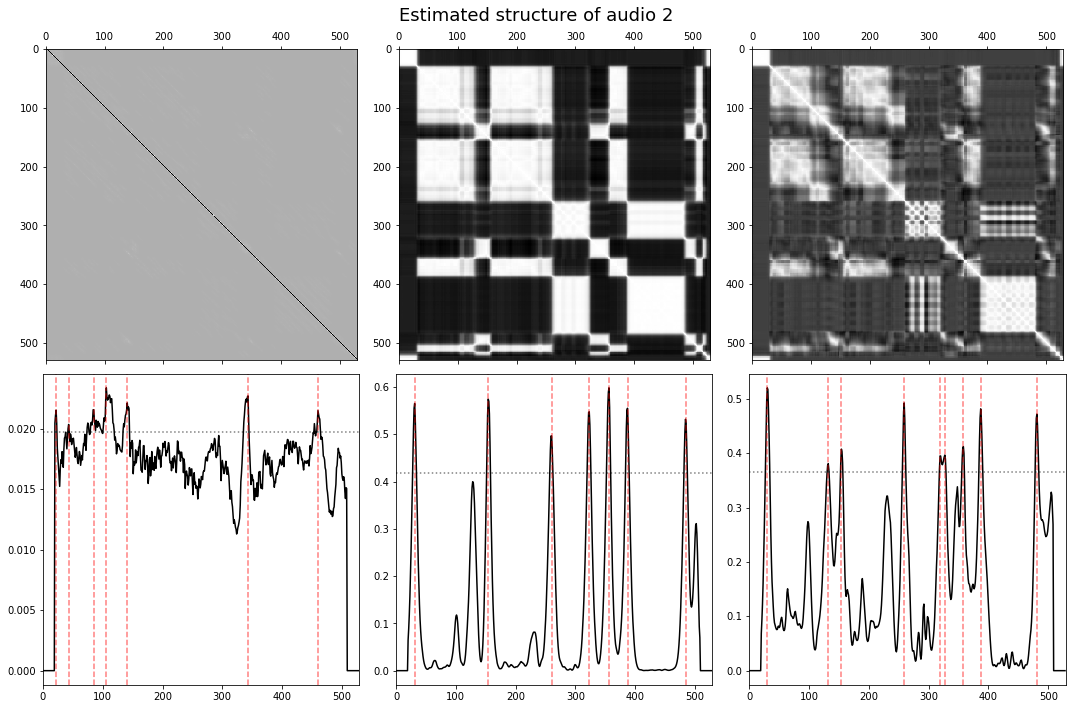

In [252]:
exp['c1']['peaks'] = scipy.signal.find_peaks(exp['c1']['nov'], 
                                             height=exp['c1']['pt'], 
                                             distance=15)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, case in enumerate(['c1', 'c2', 'c3']):

    ax[0, i].matshow(exp[case]['rep'], cmap='Greys')
    ax[1, i].plot(exp[case]['nov'], color='black')
    ax[1, i].set_xlim(0, exp[case]['nov'].shape[0])
    ax[1, i].axhline(exp[case]['pt'], color='black', ls=':', alpha=0.5)
    for peak in exp[case]["peaks"][0]:
        ax[1, i].axvline(peak, color='r', ls='--', alpha=0.5)

fig.suptitle("Estimated structure of " + "audio 2", fontsize=18) 
plt.tight_layout()
plt.show()                

That's better, but obviously the peaks are a lot different to the approximation ones. In subsequent experiments, I will have to iterate of different approximation granularities, peak-picking thresholds, peak distances, feature dimensionality etc., but for this assignment due to the computational resources and time needed I have to limit the parameter choices.

### Compute novelty functions

Now it's time to compute! We'll store the novelty functions to RAM, so that we can iterate over threshold parameters. Let's get all audio file paths and sort them, in order to easily choose subsets of them later if needed.

In [94]:
# change audio directory here
audio_dir = "../salami-audio/"

unsorted_paths = []

for path in pathlib.Path(audio_dir).glob('**/*'):
    if path.is_file() and "wav" in str(path):
        unsorted_paths.append(path)

# let's get the song paths in order so that we can more easily
# compute subsets of the dataset

# get all numbers in parent folder names, and sort them
parent_numbers = []
for path in unsorted_paths:
    # get name of parent folder of song
    parent_name = int(str(pathlib.Path(*path.parts[-2:-1])))
    parent_numbers.append(parent_name)
parent_numbers = sorted(parent_numbers)

# resynthesize the file paths
paths = []
for number in parent_numbers:
    paths.append(pathlib.Path(audio_dir+str(number)+"/audio_mp3-to.wav"))



In [255]:
# dictionary with song parent folder name being the primary key, with secondary key 
# "L", "a1", and "a2", as with the experiment above
features = {}

# define song number, needs to be <=1446
song_no = 10

if song_no > 1446:
    song_no = 1446

counter = 0
for path in paths[:song_no]:
    p_name = str(pathlib.Path(*path.parts[-2:-1]))
    features[p_name] = {}

    L, a1, a2 = get_representations(str(path))
    features[p_name]["L"] = np.abs(compute_novelty(L))
    features[p_name]["a1"] = np.abs(compute_novelty(a1))
    features[p_name]["a2"] = np.abs(compute_novelty(a2))

    counter += 1
    sys.stdout.write("\rComputed for %i/1446 audio files." % (counter))
    sys.stdout.flush()


Computed for 10/1446 audio files.

**Optional**: For peace of mind, let's save the novelty functions for each representation and each song - should be only around 20MBs.

In [262]:
# define feature directory here
feature_dir = "../salami-features/"

for song in list(features.keys()):
    np.save(feature_dir+song+"-"+"L.npy", features[song]['L'])
    np.save(feature_dir+song+"-"+"a1.npy", features[song]['a1'])
    np.save(feature_dir+song+"-"+"a2.npy", features[song]['a2'])


### Loading evaluation